# Fraud Detection Project

## Imports and Setup

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from datetime import timedelta

## Data Loading and Preprocessing

In [2]:
# # Load data
data = pd.read_csv('bank_transactions_data_2.csv')

# Data Exploration
print("Initial Dataset Info:")
data.info()

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  Ac

In [3]:
# Handling missing values
missing_values = data.isnull().sum()
# print("\nMissing Values by Column:")
# print(missing_values)

# If there are missing values, we can fill them with the mean or median of the column
if missing_values.sum() > 0:
    # Impute missing values
    data.fillna(data.median(numeric_only=True), inplace=True)
else:
    print("No missing values found")

No missing values found


In [4]:
# Convert timestamp fields to datetime
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])

# Previous Transaction Date is flawed, so we will regenerate it for this analysis
# In the real world, we would need to get the correct data
data['PreviousTransactionDate'] = data['TransactionDate']

# Function to generate a randomized previous transaction date
def random_previous_date(transaction_date):
    # Generate a random timedelta within one year (365 days)
    max_days = 60 # 2 months
    random_days = random.randint(0, max_days) 
    random_time_delta = timedelta(days=random_days)
    
    # Generate random hours, minutes, and seconds
    random_hours = random.randint(0, 23)
    random_minutes = random.randint(0, 59)
    random_seconds = random.randint(0, 59)
    random_time = timedelta(hours=random_hours, minutes=random_minutes, seconds=random_seconds)
    
    # Subtract the random time from the transaction date
    return transaction_date - random_time_delta - random_time

# Apply the function to generate new "Previous Transaction Date"
data['PreviousTransactionDate'] = data['TransactionDate'].apply(random_previous_date)

# Save the updated data to a new CSV
output_path = 'updated_bank_transactions_data.csv'
data.to_csv(output_path, index=False)

print(f"Updated dataset saved to {output_path}")

Updated dataset saved to updated_bank_transactions_data.csv


## Feature Engineering

In [5]:
# Calculate time since last transaction
data['TimeSinceLastTransaction'] = ((data['TransactionDate'] - data['PreviousTransactionDate']).dt.total_seconds())/3600 # Convert to hours
data['TransactionHour'] = data['TransactionDate'].dt.hour  # Extract transaction hour

# Count unique IP addresses per AccountID
ip_changes = data.groupby('AccountID')['IP Address'].nunique()
data['IPChangeFrequency'] = data['AccountID'].map(ip_changes)

# Compute transaction frequency by Location
location_transaction_counts = data['Location'].value_counts()
data['LocationTransactionFrequency'] = data['Location'].map(location_transaction_counts)

# Saves copy of data before encoding categorical variables
data_copy = data.copy()

# Encode categorical variables
categorical_columns = ['TransactionType', 'Location', 'DeviceID', 'MerchantID', 'Channel', 'CustomerOccupation']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

## Exploratory Data Analysis (EDA)

In [6]:
print("\nStatistics Summary:")
print(data.describe())


Statistics Summary:
       TransactionAmount                TransactionDate  TransactionType  \
count        2512.000000                           2512      2512.000000   
mean          297.593778  2023-07-05 20:32:10.826433024         0.773885   
min             0.260000            2023-01-02 16:00:06         0.000000   
25%            81.885000  2023-04-03 16:22:05.750000128         1.000000   
50%           211.140000     2023-07-07 17:49:43.500000         1.000000   
75%           414.527500     2023-10-06 18:40:53.500000         1.000000   
max          1919.110000            2024-01-01 18:21:50         1.000000   
std           291.946243                            NaN         0.418398   

          Location     DeviceID   MerchantID      Channel  CustomerAge  \
count  2512.000000  2512.000000  2512.000000  2512.000000  2512.000000   
mean     21.032643   337.732882    48.523885     0.991242    44.673965   
min       0.000000     0.000000     0.000000     0.000000    18.000000  

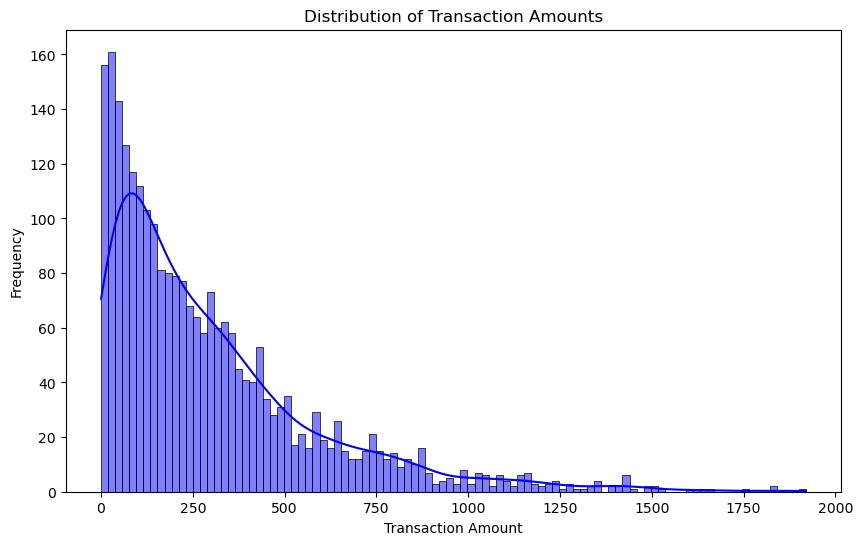

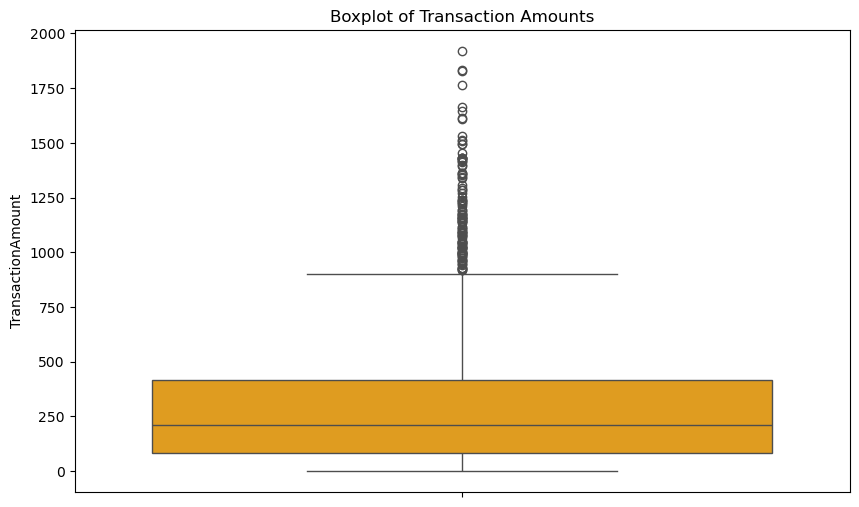

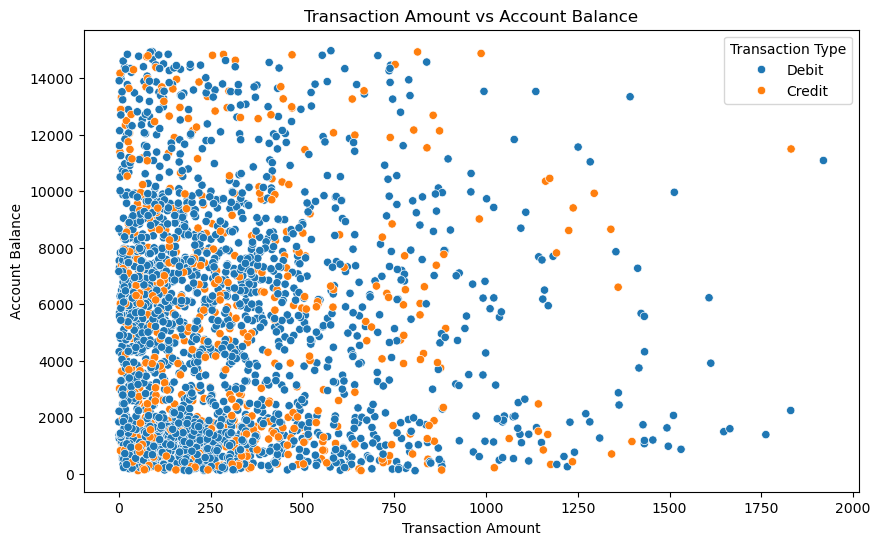

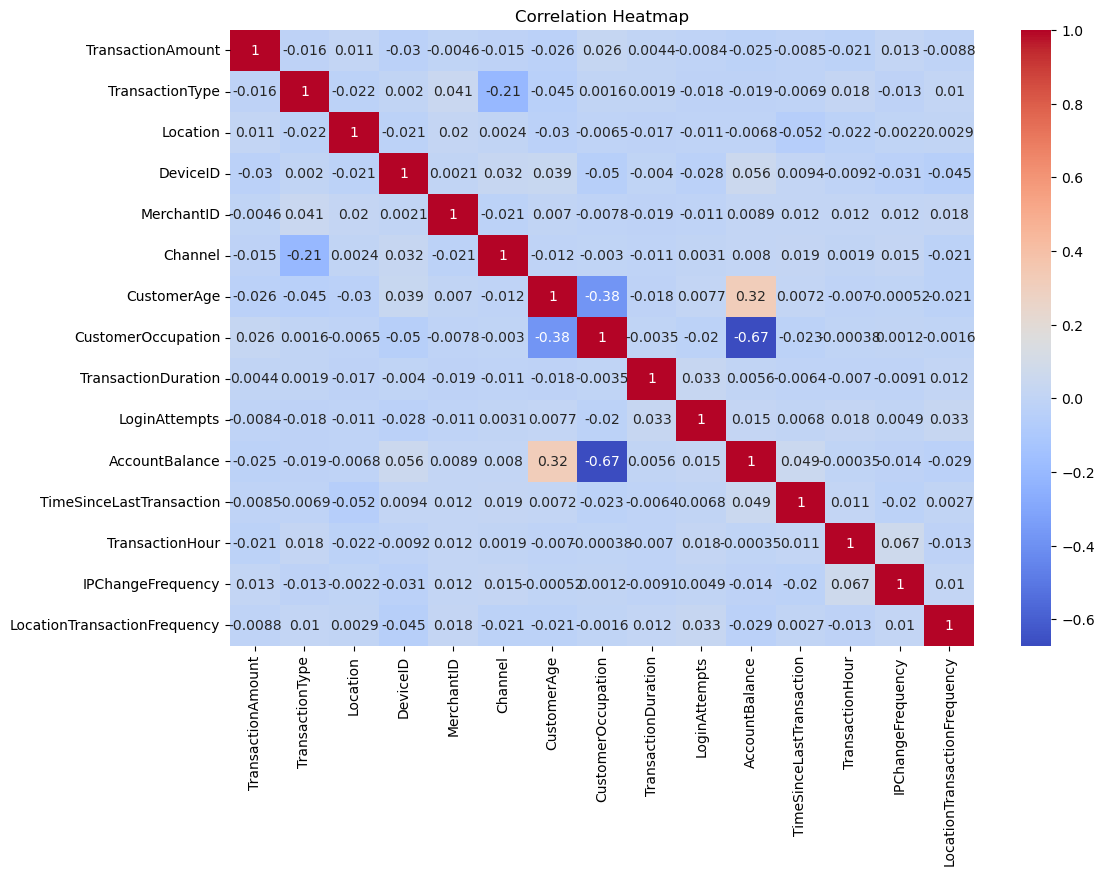

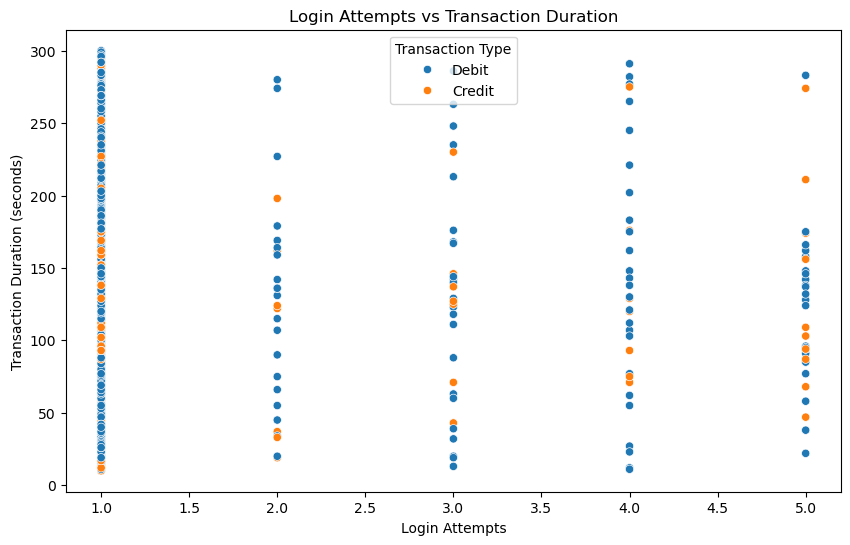

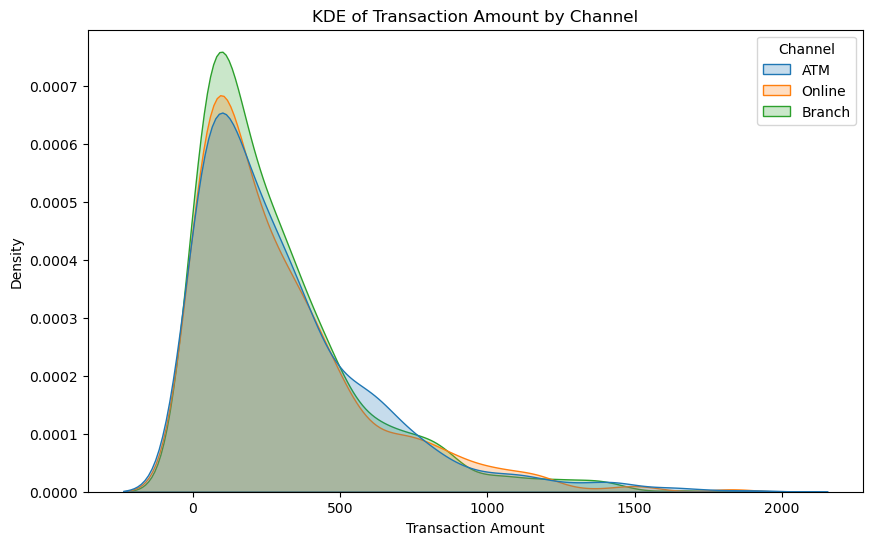

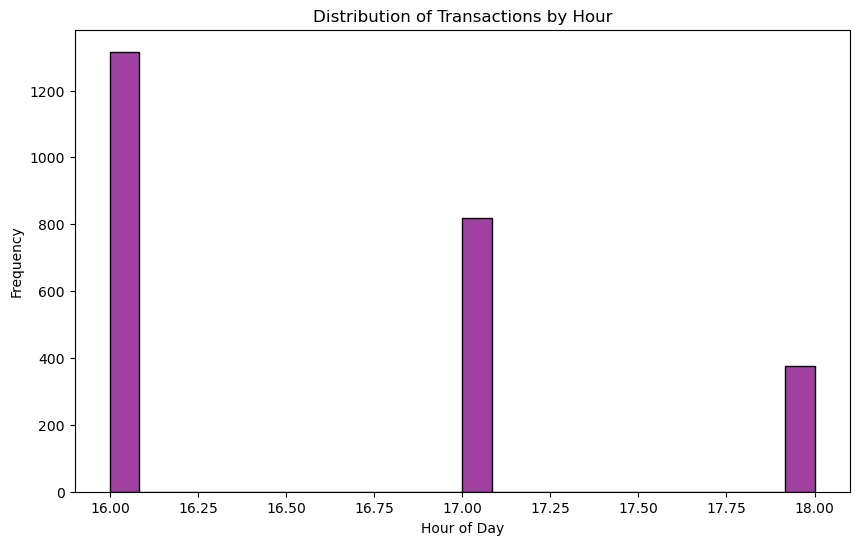

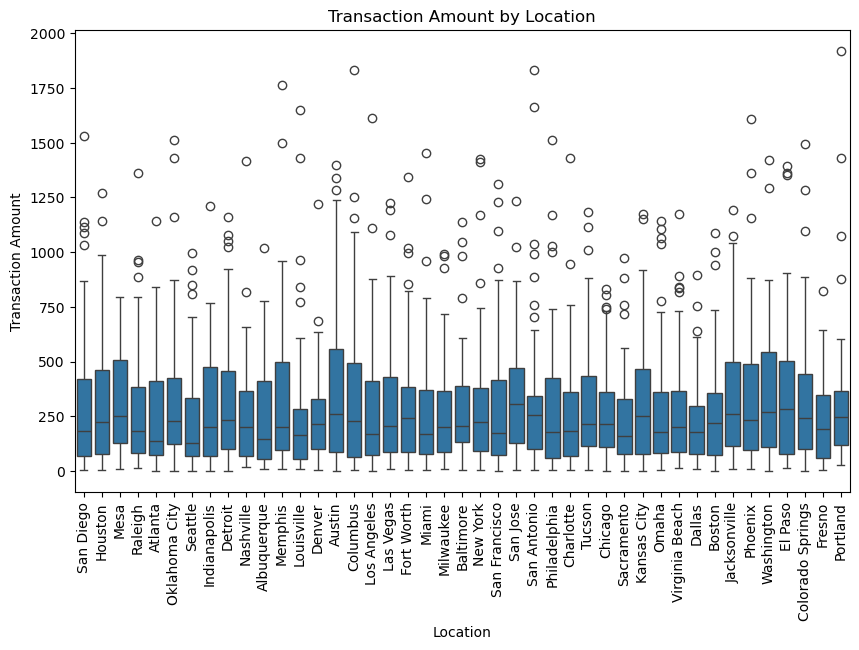

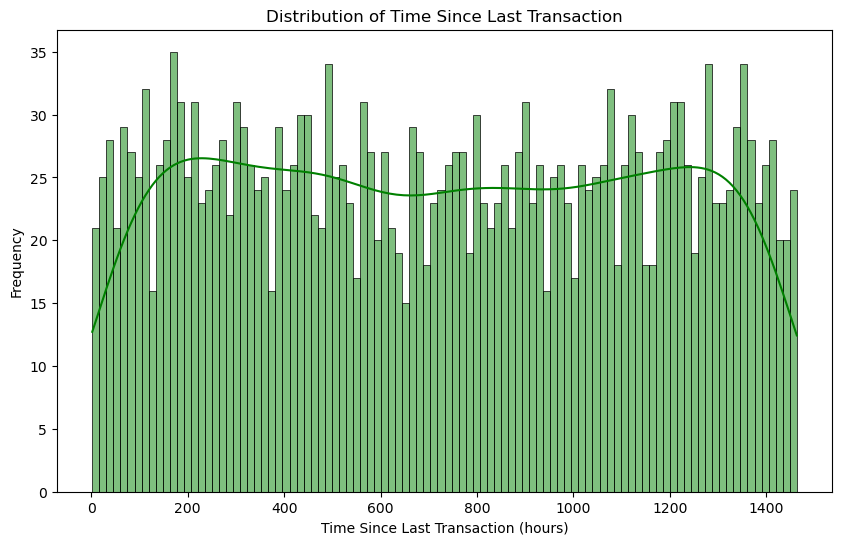

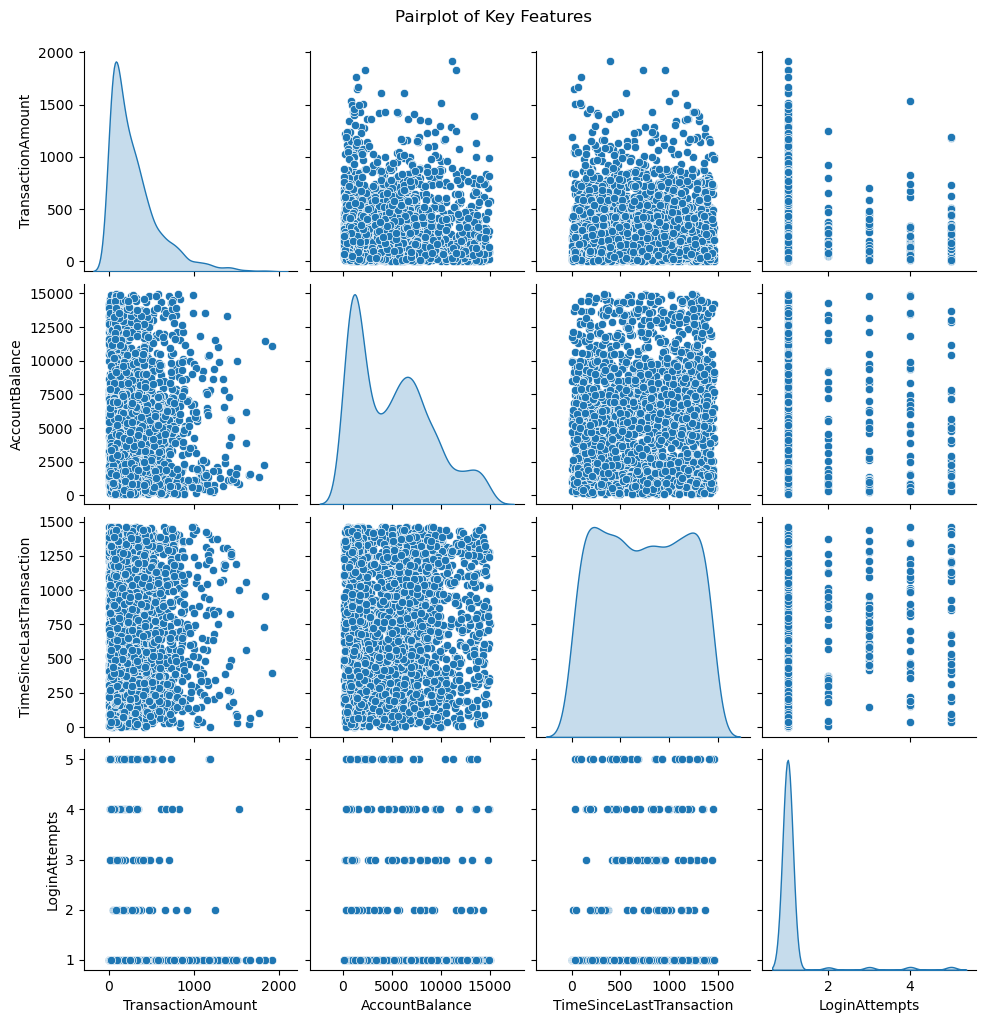

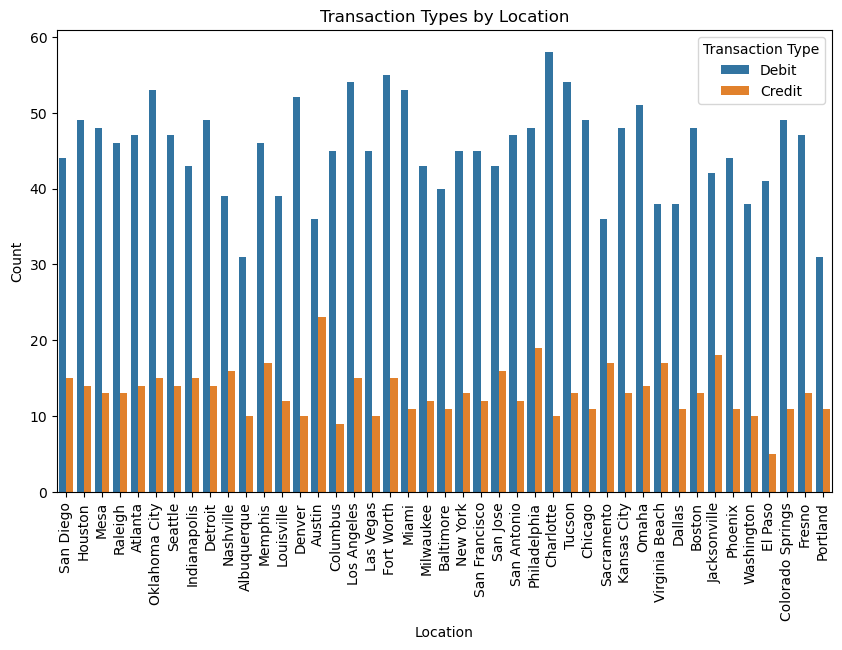

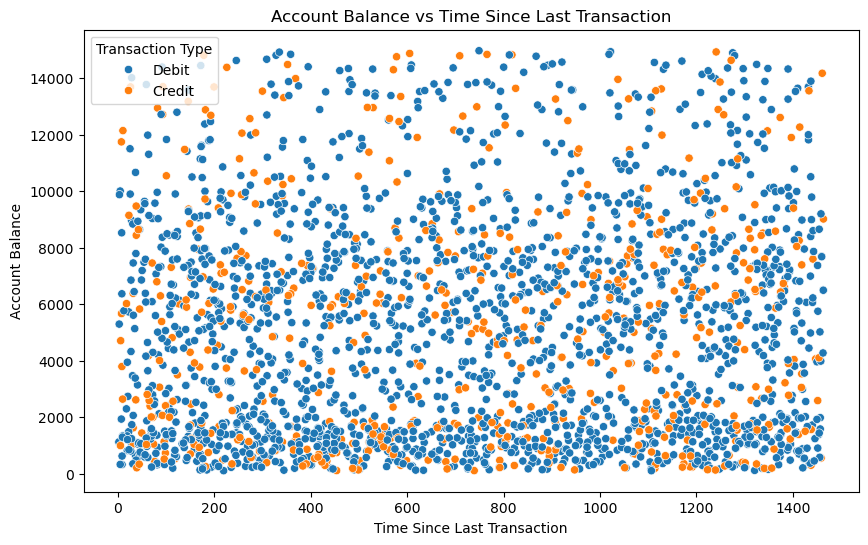

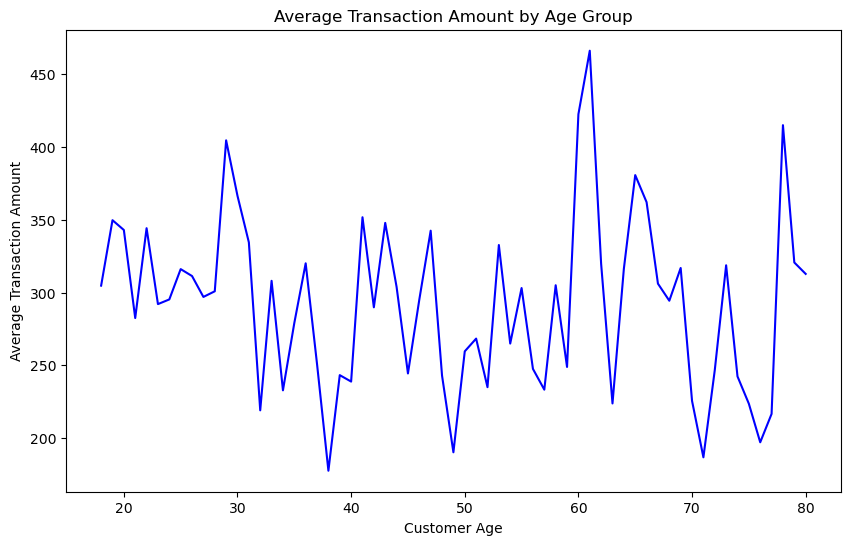

<Figure size 1000x600 with 0 Axes>

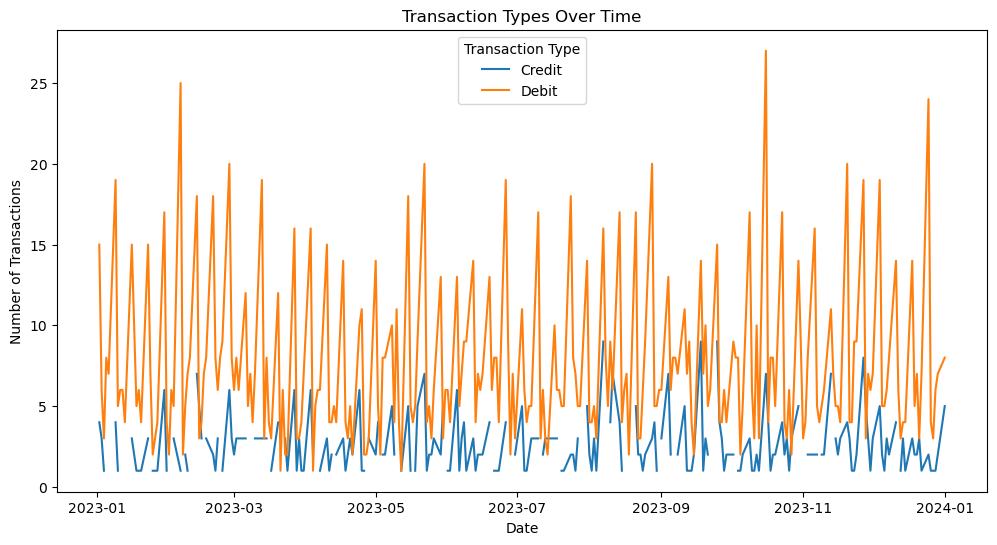

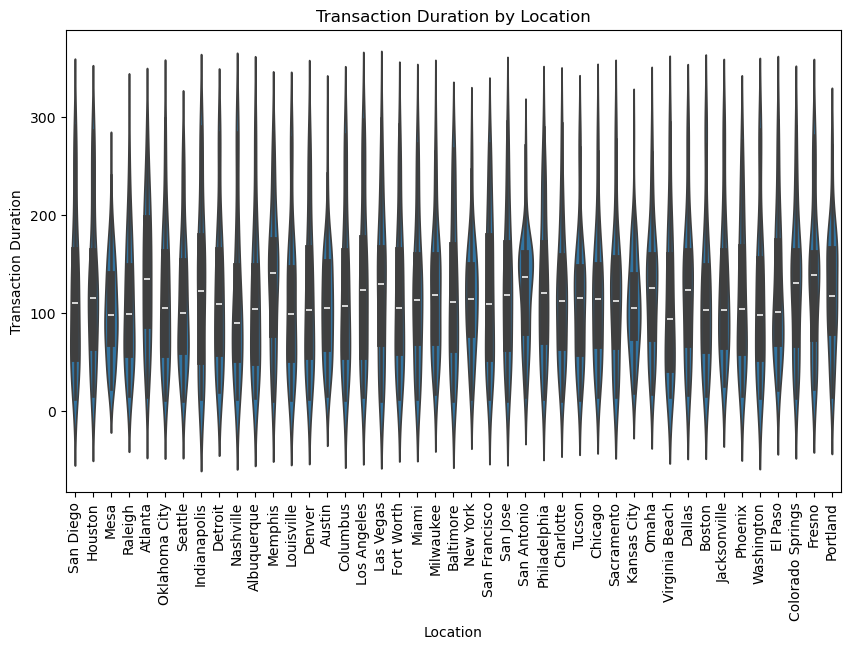

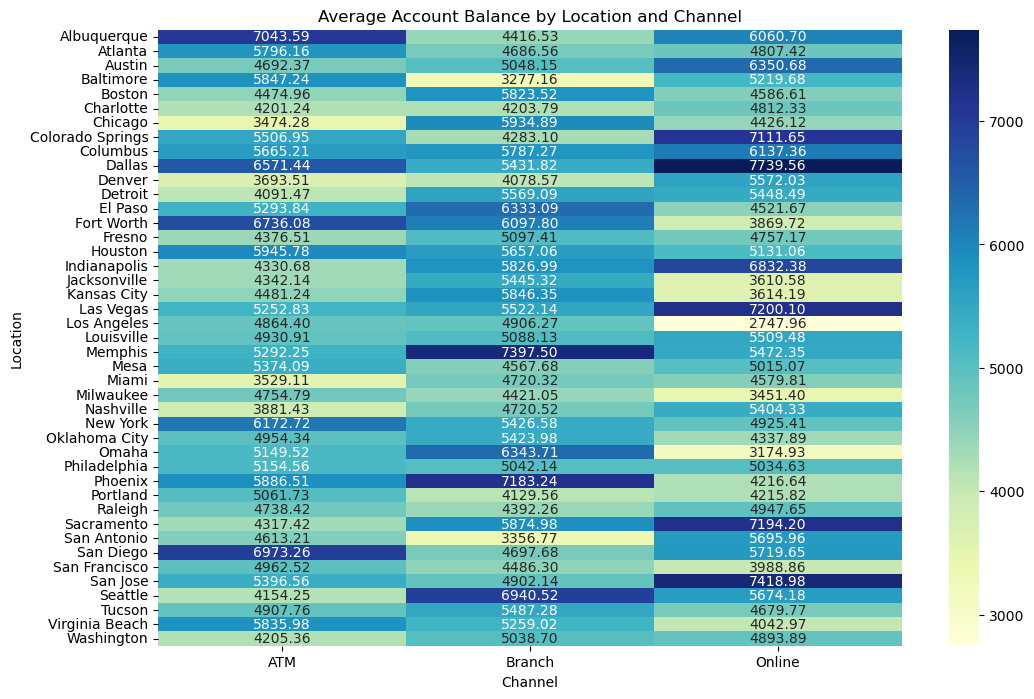

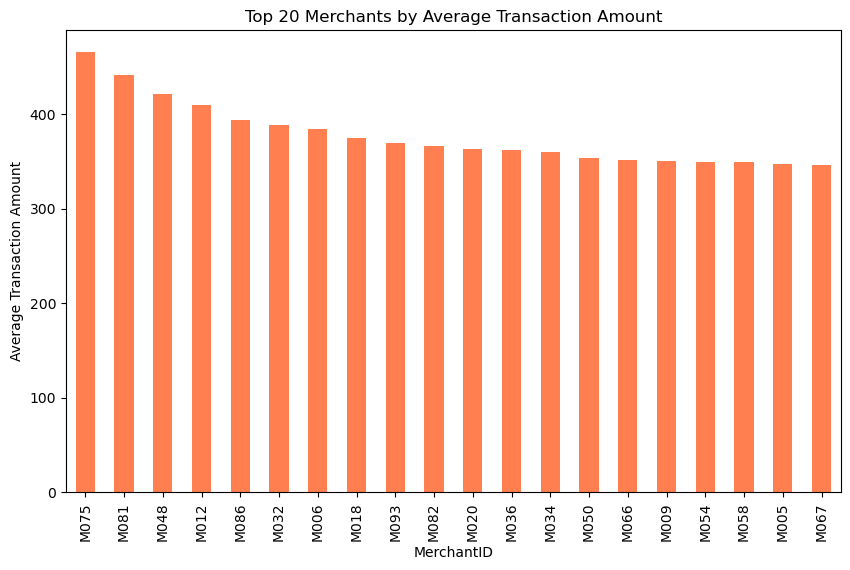

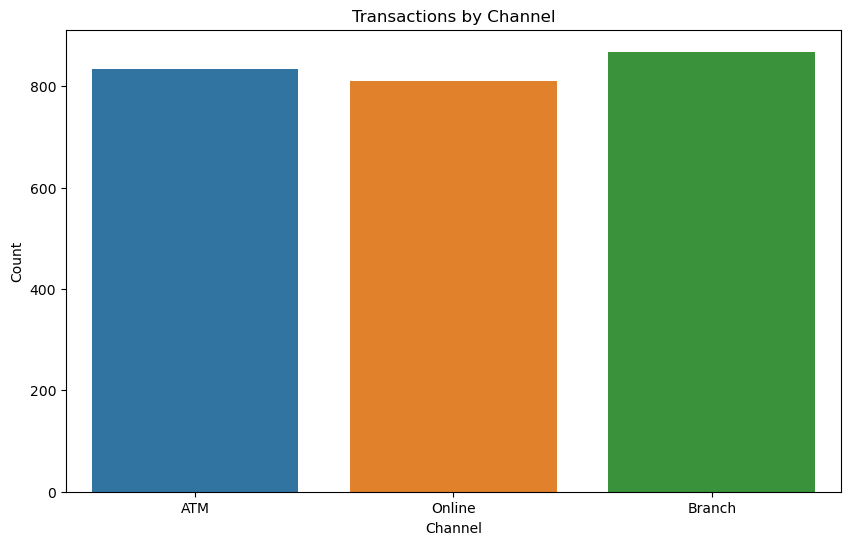

In [7]:
# Plot 1: Distribution of Transaction Amounts
plt.figure(figsize=(10, 6))
sns.histplot(data_copy['TransactionAmount'], bins=100, kde=True, color='blue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

# Plot 2: Boxplot of Transaction Amounts
plt.figure(figsize=(10, 6))
sns.boxplot(data_copy['TransactionAmount'], color='orange')
plt.title('Boxplot of Transaction Amounts')
plt.show()

# Plot 3: Scatterplot of Transaction Amount vs Account Balance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TransactionAmount', y='AccountBalance', hue='TransactionType', data=data_copy)
plt.title('Transaction Amount vs Account Balance')
plt.xlabel('Transaction Amount')
plt.ylabel('Account Balance')
plt.legend(title='Transaction Type')
plt.show()

# Plot 4: Correlation Heatmap
plt.figure(figsize=(12, 8))
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Plot 5: Login Attempts vs Transaction Duration
plt.figure(figsize=(10, 6))
sns.scatterplot(x='LoginAttempts', y='TransactionDuration', hue='TransactionType', data=data_copy)
plt.title('Login Attempts vs Transaction Duration')
plt.xlabel('Login Attempts')
plt.ylabel('Transaction Duration (seconds)')
plt.legend(title='Transaction Type')
plt.show()

# Plot 6: KDE Plot of Transaction Amount by Channel
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data_copy, x='TransactionAmount', hue='Channel', fill=True)
plt.title('KDE of Transaction Amount by Channel')
plt.xlabel('Transaction Amount')
plt.ylabel('Density')
plt.show()

# Plot 7: Distribution of Transactions by Hour
plt.figure(figsize=(10, 6))
sns.histplot(data_copy['TransactionHour'], bins=24, kde=False, color='purple')
plt.title('Distribution of Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

# Plot 8: Boxplot of Transaction Amount by Location
plt.figure(figsize=(10, 6))
sns.boxplot(x='Location', y='TransactionAmount', data=data_copy)
plt.xticks(rotation=90)
plt.title('Transaction Amount by Location')
plt.xlabel('Location')
plt.ylabel('Transaction Amount')
plt.show()

# Plot 9: Distribution of Time Since Last Transaction
plt.figure(figsize=(10, 6))
sns.histplot(data_copy['TimeSinceLastTransaction'], bins=100, kde=True, color='green')
plt.title('Distribution of Time Since Last Transaction')
plt.xlabel('Time Since Last Transaction (hours)')
plt.ylabel('Frequency')
plt.show()

# Plot 10: Pairplot of Key Features
key_features = ['TransactionAmount', 'AccountBalance', 'TimeSinceLastTransaction', 'LoginAttempts']
sns.pairplot(data_copy[key_features], diag_kind='kde')
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.show()

# Plot 11: Countplot of Transaction Types by Location
plt.figure(figsize=(10, 6))
sns.countplot(x='Location', hue='TransactionType', data=data_copy)
plt.xticks(rotation=90)
plt.title('Transaction Types by Location')
plt.xlabel('Location')
plt.ylabel('Count')
plt.legend(title='Transaction Type')
plt.show()

# Plot 12: Scatterplot of Account Balance vs Time Since Last Transaction
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TimeSinceLastTransaction', y='AccountBalance', hue='TransactionType', data=data_copy)
plt.title('Account Balance vs Time Since Last Transaction')
plt.xlabel('Time Since Last Transaction')
plt.ylabel('Account Balance')
plt.legend(title='Transaction Type')
plt.show()

# Plot 13: Average Transaction Amount by Age Group
plt.figure(figsize=(10, 6))
avg_transaction_by_age = data_copy.groupby('CustomerAge')['TransactionAmount'].mean()
avg_transaction_by_age.plot(kind='line', color='blue')
plt.title('Average Transaction Amount by Age Group')
plt.xlabel('Customer Age')
plt.ylabel('Average Transaction Amount')
plt.show()

# Plot 14: Transaction Types Over Time
plt.figure(figsize=(10, 6))
data_copy['TransactionDateOnly'] = data_copy['TransactionDate'].dt.date
daily_transactions = data_copy.groupby(['TransactionDateOnly', 'TransactionType']).size().unstack()
daily_transactions.plot(kind='line', figsize=(12, 6))
plt.title('Transaction Types Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.legend(title='Transaction Type')
plt.show()

# Plot 15: Distribution of Transaction Durations by Location
plt.figure(figsize=(10, 6))
sns.violinplot(x='Location', y='TransactionDuration', data=data_copy)
plt.xticks(rotation=90)
plt.title('Transaction Duration by Location')
plt.xlabel('Location')
plt.ylabel('Transaction Duration')
plt.show()

# Plot 16: Heatmap of Average Account Balance by Location and Channel
avg_balance = data_copy.pivot_table(values='AccountBalance', index='Location', columns='Channel', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(avg_balance, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Average Account Balance by Location and Channel')
plt.xlabel('Channel')
plt.ylabel('Location')
plt.show()

# Plot 17: Average Transaction Amount by Merchant
plt.figure(figsize=(10, 6))
avg_transaction_by_merchant = data_copy.groupby('MerchantID')['TransactionAmount'].mean()
avg_transaction_by_merchant.sort_values(ascending=False).head(20).plot(kind='bar', color='coral')
plt.title('Top 20 Merchants by Average Transaction Amount')
plt.xlabel('MerchantID')
plt.ylabel('Average Transaction Amount')
plt.show()

# Plot 18: Distribution of Transactions by Channel
plt.figure(figsize=(10, 6))
sns.countplot(x='Channel', data=data_copy, hue='Channel', legend=False)
plt.title('Transactions by Channel')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.show()


In [8]:
# Dropping Features
data = data.drop(['CustomerOccupation', 'DeviceID', 'TransactionDuration'], axis=1)

# Standardize numerical features for clustering and anomaly detection
numerical_features = ['TransactionAmount', 'TransactionType', 'Location', 'MerchantID', 'Channel', 'CustomerAge', 
                      'LoginAttempts', 'AccountBalance', 'TimeSinceLastTransaction', 
                      'TransactionHour', 'IPChangeFrequency', 'LocationTransactionFrequency']
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[numerical_features])

## Anomaly Detection with Five Models

In [9]:
# Perform PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data_scaled)
pca_df = pd.DataFrame(pca_data, columns=['PCA1', 'PCA2'])

In [10]:
# Anomaly detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
data['IsoForest_AnomalyBinary'] = iso_forest.fit_predict(data_scaled)
pca_df['IsoForest_AnomalyBinary'] = iso_forest.fit_predict(pca_data)

# Anomaly detection using Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=False)
lof.fit(data_scaled)
data['LOF_AnomalyBinary'] = lof.fit_predict(data_scaled)
pca_df['LOF_AnomalyBinary'] = lof.fit_predict(pca_data)

# Anomaly detection using One-Class SVM
ocsvm = OneClassSVM(nu=0.05, kernel='rbf', gamma=0.1)
data['OCSVM_AnomalyBinary'] = ocsvm.fit_predict(data_scaled)
pca_df['OCSVM_AnomalyBinary'] = ocsvm.fit_predict(pca_data)

# Clustering-based anomaly detection using KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_pca = KMeans(n_clusters=3, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(data_scaled)
pca_df['KMeans_Cluster'] = kmeans_pca.fit_predict(pca_data)

# Identify anomalies as points farthest from their cluster centroids
data['KMeans_DistanceToCentroid'] = [
    np.linalg.norm(data_scaled[i] - kmeans.cluster_centers_[cluster]) 
    for i, cluster in enumerate(data['KMeans_Cluster'])
]
# Compute distances to centroids for PCA data
pca_df['KMeans_DistanceToCentroid'] = [
    np.linalg.norm(pca_data[i] - kmeans_pca.cluster_centers_[cluster]) 
    for i, cluster in enumerate(pca_df['KMeans_Cluster'])
]


# Define threshold for anomalies based on distance (e.g., 90th percentile)
kmeans_threshold = np.percentile(data['KMeans_DistanceToCentroid'], 90)
kmeans_threshold_pca = np.percentile(pca_df['KMeans_DistanceToCentroid'], 90)
data['KMeans_AnomalyBinary'] = (data['KMeans_DistanceToCentroid'] > kmeans_threshold).astype(int)
pca_df['KMeans_AnomalyBinary'] = (pca_df['KMeans_DistanceToCentroid'] > kmeans_threshold_pca).astype(int)

silhouette_avg_data = silhouette_score(data_scaled, data['KMeans_Cluster'])
silhouette_avg_pca = silhouette_score(pca_data, pca_df['KMeans_Cluster'])
print(f"Silhouette Score for K-Means Clustering on Original Data: {silhouette_avg_data:.2f}")
print(f"Silhouette Score for K-Means Clustering on PCA Data: {silhouette_avg_pca:.2f}")

# Anomaly detection using DBSCAN
dbscan = DBSCAN(eps=0.15, min_samples=5, metric='manhattan')
data['DBSCAN_Cluster'] = dbscan.fit_predict(data_scaled)
pca_df['DBSCAN_Cluster'] = dbscan.fit_predict(pca_data)

data['DBSCAN_AnomalyBinary'] = (data['DBSCAN_Cluster'] == -1).astype(int)
pca_df['DBSCAN_AnomalyBinary'] = (pca_df['DBSCAN_Cluster'] == -1).astype(int)


# Normalize anomaly labels to 0 and 1
data['IsoForest_AnomalyBinary'] = (data['IsoForest_AnomalyBinary'] == -1).astype(int)
data['LOF_AnomalyBinary'] = (data['LOF_AnomalyBinary'] == -1).astype(int)
data['OCSVM_AnomalyBinary'] = (data['OCSVM_AnomalyBinary'] == -1).astype(int)
pca_df['IsoForest_AnomalyBinary'] = (pca_df['IsoForest_AnomalyBinary'] == -1).astype(int)
pca_df['LOF_AnomalyBinary'] = (pca_df['LOF_AnomalyBinary'] == -1).astype(int)
pca_df['OCSVM_AnomalyBinary'] = (pca_df['OCSVM_AnomalyBinary'] == -1).astype(int)

Silhouette Score for K-Means Clustering on Original Data: 0.09
Silhouette Score for K-Means Clustering on PCA Data: 0.40


In [11]:
# Combine results from multiple models into a consensus model
def five_model_consensus(row):
    scores = [
        row['IsoForest_AnomalyBinary'],
        row['LOF_AnomalyBinary'],
        row['OCSVM_AnomalyBinary'],
        row['KMeans_AnomalyBinary'],
        row['DBSCAN_AnomalyBinary']
    ]
    return 1 if scores.count(1) > 2 else 0

data['FiveModel_ConsensusLabel'] = data.apply(five_model_consensus, axis=1)
pca_df['FiveModel_ConsensusLabel'] = pca_df.apply(five_model_consensus, axis=1)

print("\nFive Model Consensus Anomaly Detection Results (Original Data):")
print(data['FiveModel_ConsensusLabel'].value_counts())
print("\nFive Model Consensus Anomaly Detection Results (PCA Data):")
print(pca_df['FiveModel_ConsensusLabel'].value_counts())


Five Model Consensus Anomaly Detection Results (Original Data):
FiveModel_ConsensusLabel
0    2335
1     177
Name: count, dtype: int64

Five Model Consensus Anomaly Detection Results (PCA Data):
FiveModel_ConsensusLabel
0    2381
1     131
Name: count, dtype: int64


In [12]:

# Define weights for different models
weights = {
    'IsoForest_AnomalyBinary': 3,
    'LOF_AnomalyBinary': 2,
    'OCSVM_AnomalyBinary': 2,
    'KMeans_AnomalyBinary': 2,
    'DBSCAN_AnomalyBinary': 1
}


# Compute weighted consensus anomaly scores for original data
data['Weighted_Consensus_AnomalyScore'] = (
    weights['IsoForest_AnomalyBinary'] * data['IsoForest_AnomalyBinary']+
    weights['LOF_AnomalyBinary'] * data['LOF_AnomalyBinary'] +
    weights['OCSVM_AnomalyBinary'] * data['OCSVM_AnomalyBinary']+
    weights['KMeans_AnomalyBinary'] * data['KMeans_AnomalyBinary'] +
    weights['DBSCAN_AnomalyBinary'] * data['DBSCAN_AnomalyBinary']
)

# Compute weighted consensus anomaly scores for PCA-reduced data
pca_df['Weighted_Consensus_AnomalyScore'] = (
    weights['IsoForest_AnomalyBinary'] * pca_df['IsoForest_AnomalyBinary']+
    weights['LOF_AnomalyBinary'] * pca_df['LOF_AnomalyBinary'] +
    weights['OCSVM_AnomalyBinary'] * pca_df['OCSVM_AnomalyBinary'] +
    weights['KMeans_AnomalyBinary'] * pca_df['KMeans_AnomalyBinary'] +
    weights['DBSCAN_AnomalyBinary'] * pca_df['DBSCAN_AnomalyBinary']
)

# Mark anomalies based on a threshold (e.g., majority weighted agreement)
# Dynamically determine threshold (e.g., 95th percentile)
anomaly_threshold = np.percentile(data['Weighted_Consensus_AnomalyScore'], 95)
anomaly_threshold_pca = np.percentile(pca_df['Weighted_Consensus_AnomalyScore'], 95)

data['Final_AnomalyLabel'] = (data['Weighted_Consensus_AnomalyScore'] >= anomaly_threshold).astype(int)
pca_df['Final_AnomalyLabel'] = (pca_df['Weighted_Consensus_AnomalyScore'] >= anomaly_threshold_pca).astype(int)

# Results
print("\nWeighted Consensus Anomaly Detection Results (Original Data):")
print(data['Final_AnomalyLabel'].value_counts())
print("\nWeighted Consensus Anomaly Detection Results (PCA Data):")
print(pca_df['Final_AnomalyLabel'].value_counts())


Weighted Consensus Anomaly Detection Results (Original Data):
Final_AnomalyLabel
0    2379
1     133
Name: count, dtype: int64

Weighted Consensus Anomaly Detection Results (PCA Data):
Final_AnomalyLabel
0    2372
1     140
Name: count, dtype: int64


## Visualization of Consensus Labels

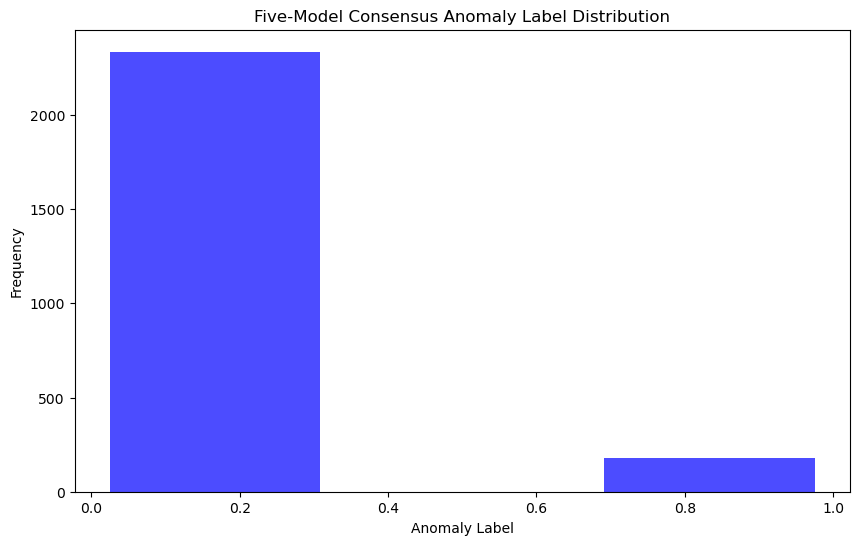

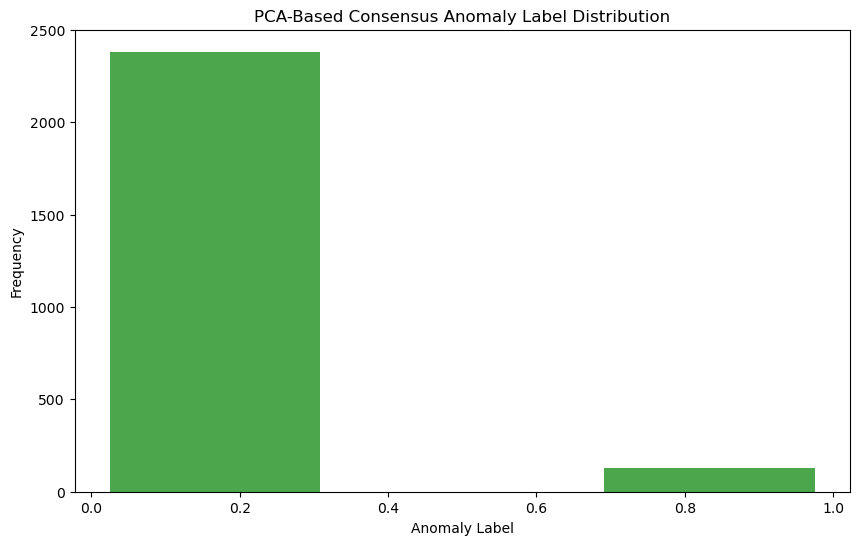

-----------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------


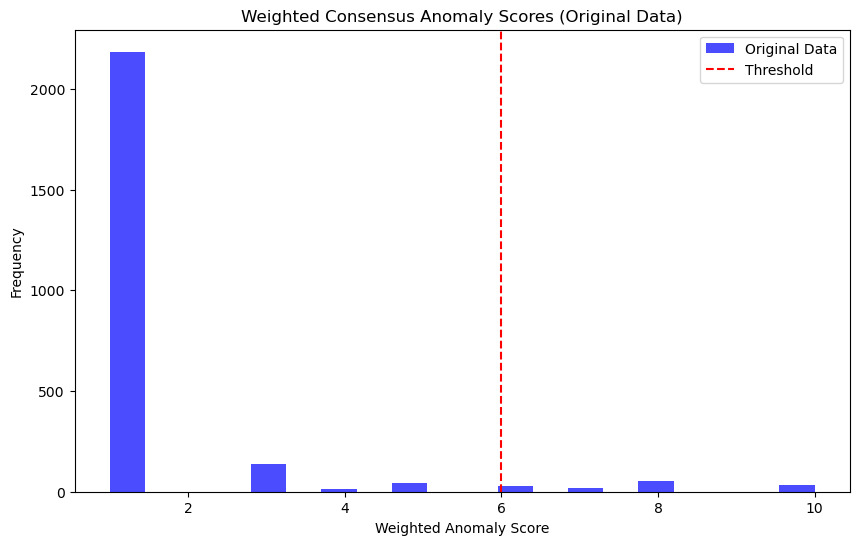

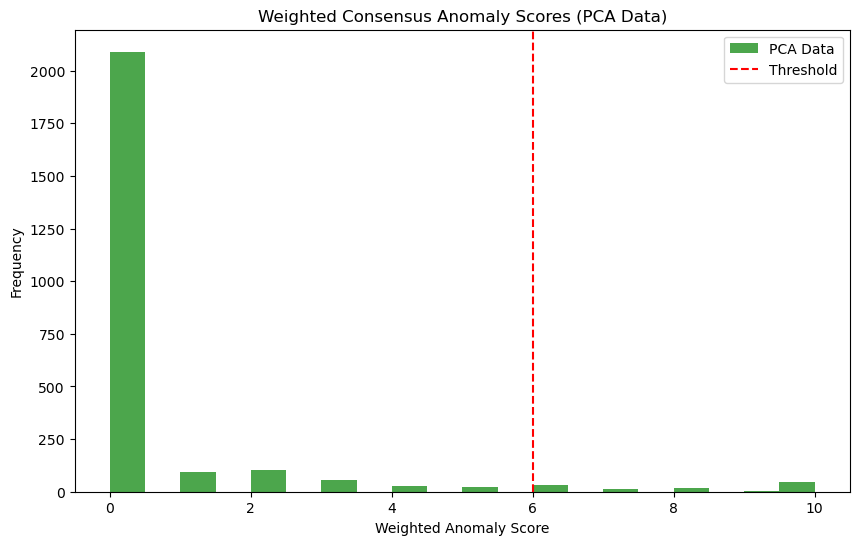

-----------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------


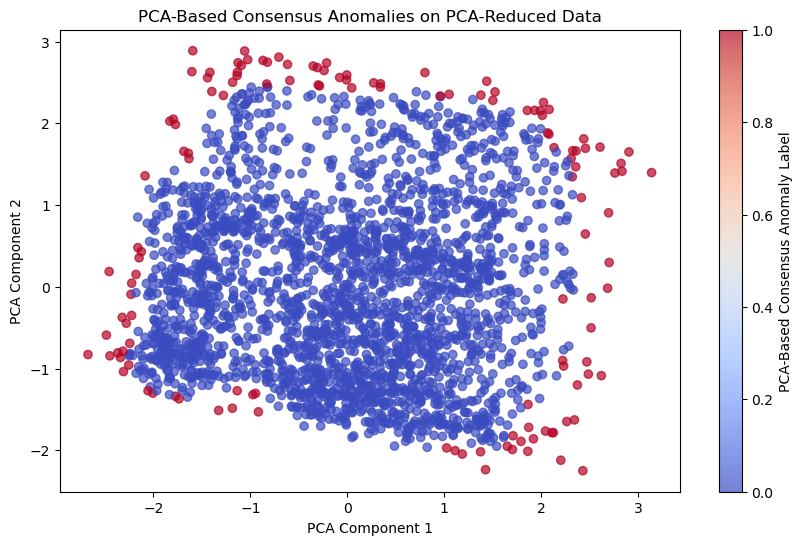

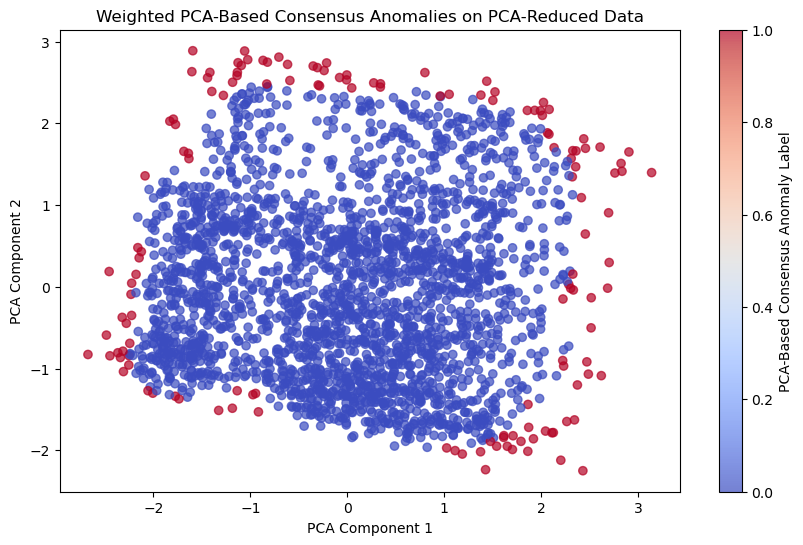

In [13]:
# Alternative Visualization for Five-Model Consensus
plt.figure(figsize=(10, 6))
plt.hist(data['FiveModel_ConsensusLabel'], bins=3, alpha=0.7, color='blue', rwidth=0.85)
plt.title("Five-Model Consensus Anomaly Label Distribution")
plt.xlabel("Anomaly Label")
plt.ylabel("Frequency")
plt.show()

# Alternative Visualization for PCA-Based Consensus
plt.figure(figsize=(10, 6))
plt.hist(pca_df['FiveModel_ConsensusLabel'], bins=3, alpha=0.7, color='green', rwidth=0.85)
plt.title("PCA-Based Consensus Anomaly Label Distribution")
plt.xlabel("Anomaly Label")
plt.ylabel("Frequency")
plt.show()

print('-----------------------------------------------------------------------------------------------------------------------')
print('-----------------------------------------------------------------------------------------------------------------------')

# Visualization for Weighted Consensus Anomaly Scores
plt.figure(figsize=(10, 6))
plt.hist(data['Weighted_Consensus_AnomalyScore'], bins=20, alpha=0.7, color='blue', label='Original Data')
plt.axvline(x=anomaly_threshold, color='red', linestyle='--', label='Threshold')
plt.title("Weighted Consensus Anomaly Scores (Original Data)")
plt.xlabel("Weighted Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(pca_df['Weighted_Consensus_AnomalyScore'], bins=20, alpha=0.7, color='green', label='PCA Data')
plt.axvline(x=anomaly_threshold, color='red', linestyle='--', label='Threshold')
plt.title("Weighted Consensus Anomaly Scores (PCA Data)")
plt.xlabel("Weighted Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print('-----------------------------------------------------------------------------------------------------------------------')
print('-----------------------------------------------------------------------------------------------------------------------')

# Visualize PCA-Based Consensus Anomalies
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    pca_df['PCA1'], pca_df['PCA2'],
    c=pca_df['FiveModel_ConsensusLabel'],
    cmap='coolwarm', alpha=0.7
)
plt.colorbar(scatter, label="PCA-Based Consensus Anomaly Label")
plt.title("PCA-Based Consensus Anomalies on PCA-Reduced Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Visualize PCA-Based Consensus Anomalies
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    pca_df['PCA1'], pca_df['PCA2'],
    c=pca_df['Final_AnomalyLabel'],
    cmap='coolwarm', alpha=0.7
)
plt.colorbar(scatter, label="PCA-Based Consensus Anomaly Label")
plt.title("Weighted PCA-Based Consensus Anomalies on PCA-Reduced Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

## Analysis of Models

In [14]:
# Initialize Groq API for LLM Integration
from groq import Groq
from IPython.display import Markdown, display

total_transactions = len(data)
anomaly_count = pca_df['Final_AnomalyLabel'].sum()
anomaly_percentage = (anomaly_count / total_transactions) * 100

client = Groq(
    api_key="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",
)

def generate_insights(data_description):
    """Use LLM to generate insights about the data."""
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": f"You are an experienced financial analyst. Analyze the following dataset description and provide key insights: {data_description}",
            }
        ],
        model="llama3-8b-8192",
    )
    return chat_completion.choices[0].message.content

def explain_model_output(transaction_features):
    """Use LLM to explain why a transaction was flagged as an anomaly."""
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": (
                    f"You are an experienced financial analyst in charge of detecting fraudulent activity. Explain why the following transaction features might indicate an anomaly:\n"
                    f"{transaction_features}\nInclude potential reasons based on patterns observed in financial transactions."
                ),
            }
        ],
        model="llama3-8b-8192",
    )
    return chat_completion.choices[0].message.content

# Example LLM Usage
data_description = (
    "A dataset containing:\n" 
    "TransactionID: Unique alphanumeric identifier for each transaction;\n" 
    "AccountID: Unique identifier for each account, with multiple transactions per account;\n" 
    "TransactionAmount: Monetary value of each transaction, ranging from small everyday expenses to larger purchases;\n" 
    "TransactionDate: Timestamp of each transaction, capturing date and time;\n" 
    "TransactionType: Categorical field indicating 'Credit' or 'Debit' transactions;\n" 
    "Location: Geographic location of the transaction, represented by U.S. city names;\n" 
    "DeviceID: Alphanumeric identifier for devices used to perform the transaction;\n" 
    "IP Address: IPv4 address associated with the transaction, with occasional changes for some accounts;\n" 
    "MerchantID: Unique identifier for merchants, showing preferred and outlier merchants for each account;\n" 
    "AccountBalance: Balance in the account post-transaction, with logical correlations based on transaction type and amount;\n"
    "PreviousTransactionDate: Timestamp of the last transaction for the account, aiding in calculating transaction frequency;\n"
    "Channel: Channel through which the transaction was performed (e.g., Online, ATM, Branch);\n" 
    "CustomerAge: Age of the account holder, with logical groupings based on occupation;\n" 
    "CustomerOccupation: Occupation of the account holder (e.g., Doctor, Engineer, Student, Retired), reflecting income patterns;\n" 
    "TransactionDuration: Duration of the transaction in seconds, varying by transaction type;\n" 
    "LoginAttempts: Number of login attempts before the transaction, with higher values indicating potential anomalies.\n"
    "Anomalies have been identified using a consensus model that is a combination of Isolation Forest, Local Outlier Factor, One-Class SVM, KMeans, and DBSCAN."
)
insights = generate_insights(data_description)
display(Markdown(f"### Transaction Data Insights:\n{insights}"))

# Example Explanation of Model Output
sample_transaction = data_copy.iloc[23].to_dict()
explanation = explain_model_output(sample_transaction)
display(Markdown(f"### Model Output Explanation:\n{explanation}"))

# Automated Reporting
def generate_report():
    """Generate a summary report using the LLM."""
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": (
                    "Create a summary report based on the following metrics and insights:\n"
                    f"Total Transactions: {total_transactions}, Fraud Suspected: {anomaly_count}, "
                    f"Anomaly Percentage: {anomaly_percentage:.2f}%\n"
                    f"Key Insights: {insights}\n"
                ),
            }
        ],
        model="llama3-70b-8192",
    )
    return chat_completion.choices[0].message.content

report = generate_report()
display(Markdown(f"### Automated Report:\n{report}"))

### Transaction Data Insights:
What a fascinating dataset! As a financial analyst, I'll dive into the key insights and potential uses of this dataset.

**Unique Identifiers:**

* TransactionID and AccountID allow for tracking individual transactions and accounts, enabling analysis of customer behavior and transaction patterns.
* DeviceID and IP Address assist in identifying user behavior and potential security threats.

**Transaction Characteristics:**

* TransactionAmount and TransactionType provide insights into spending patterns, helping identify common expense categories, such as entertainment, food, or transportation.
* TransactionDate and TransactionDuration help analyze transaction frequency, timing, and potential correlations with other variables.
* Channel information (e.g., Online, ATM, Branch) assists in understanding how customers interact with the financial institution.

**Customer Demographics:**

* AccountBalance and PreviousTransactionDate can help assess customer creditworthiness and transaction frequency.
* CustomerAge, CustomerOccupation, and IP Address (assuming geolocation) provide insights into customer demographics and potentially, income patterns.

**Anomalies and Fraud Detection:**

* The anomalies identified using the consensus model (Isolation Forest, Local Outlier Factor, One-Class SVM, KMeans, and DBSCAN) highlight suspicious transactions that may require further investigation.

**Actionable Insights:**

1. **Customer Segmentation:** Analyze customer behavior based on account characteristics (e.g., frequent transactions, high balance, or unusual spending patterns) to identify potential interest groups or loyal customers.
2. **Risk Assessment:** Use the anomaly detection results to identify potential fraudsters, and apply machine learning models to predict the likelihood of future fraudulent transactions.
3. **Personalized Marketing:** Utilize IP Address and demographic information to create targeted marketing campaigns for specific customer groups.
4. **Customer Retention:** Leverage transaction data to identify customers at risk of switching banks, and develop retention strategies to keep them engaged.
5. **Operational Optimization:** Analyze transaction duration and channel information to optimize branch operations, ATM usage, or online platforms.
6. **A/B Testing:** Design experiments to evaluate the effectiveness of different marketing campaigns, improved customer interfaces, or new fee structures.
7. **Compliance Monitoring:** Monitor account balances, transaction frequencies, and other variables to ensure compliance with regulatory requirements.

**Challenges and Opportunities:**

1. **Data Quality:** Ensure data accuracy and completeness to avoid biases in analysis and decision-making.
2. **Integration with Other Datasets:** Combine this dataset with others (e.g., credit report data, social media activity) to gain a more comprehensive understanding of customer behavior.
3. **Advanced Analytics and Visualization:** Utilize machine learning and data visualization techniques to uncover hidden patterns and dependencies in the data, such as correlations between customer demographics and spending habits.
4. **Real-time Processing:** Develop a system to process and analyze live transaction data, enabling rapid reaction to anomalies, customer behavior changes, or market trends.

Overall, this dataset provides a rich source of information for understanding customer behavior, identifying fraudulent activities, and optimizing financial institution operations. By leveraging these insights, financial institutions can improve customer satisfaction, reduce risks, and increase revenue.

### Model Output Explanation:
As an experienced financial analyst, I would flag this transaction as potentially anomalous based on the following features:

1. **TransactionAmount**: $345.84 is a relatively large debit transaction, especially considering the account balance is only $1402.50. This could indicate a suspicious or unauthorized transaction.

Pattern observed: Typically, debit transactions are small, routine expenses, such as daily purchases or bill payments.

2. **TransactionDate**: The transaction occurred at 18:25, which is late in the evening. While online transactions can occur at any time, this unusual hour may warrant further investigation.

Pattern observed: Most online transactions occur during peak hours (e.g., lunch break or evening commute).

3. **TransactionType**: A debit transaction is unusual for this account type, given the account balance is relatively low. This could indicate an unauthorized or fraudulent transaction.

Pattern observed: Credit transactions are more common for low-balance accounts, as the customer may be revolving credit or building up debt.

4. **DeviceID** and **IP Address**: The device ID and IP address are both new, indicating the customer is potentially using a previously unseen device or location.

Pattern observed: Customers typically re-use their preferred devices and locations for transactions.

5. **IPChangeFrequency**: The IP address has changed frequently (9 times) in a short period, which may indicate an attempt to evade detection.

Pattern observed: IP addresses typically remain consistent for a set period, especially when logged in.

6. **TransactionDuration**: The transaction took only 142 seconds to complete, which is relatively fast. This could indicate automated or scripted activity.

Pattern observed: Transactions typically take longer, especially for online transactions involving multiple screens and confirmations.

7. **LoginAttempts**: The customer attempted to log in 3 times before successfully making the transaction. This could indicate an attempt to brute-force or guess login credentials.

Pattern observed: Customers usually log in successfully on the first attempt.

8. **TimeSinceLastTransaction**: The time since the last transaction is relatively short (489 seconds), which may indicate a pattern of frequent, suspicious activity.

Pattern observed: The time between transactions varies, but short intervals can indicate riskier behavior.

9. **TransactionHour**: The transaction occurred during an unusual hour (18:25), which may be a red flag.

Pattern observed: Most transactions occur during standard working hours (9:00-17:00).

10. **AccountBalance**: The account balance is relatively low, which may increase the risk of overspending or fraudulent activity.

Pattern observed: Account balances tend to follow predictable patterns, with customers maintaining a minimum balance to avoid fees.

Based on these features, I would recommend further investigation to determine the legitimacy of the transaction.

### Automated Report:
**Summary Report: Transaction Data Analysis**

**Overview**

This report presents an analysis of a dataset containing 2512 transactions, with 140 suspected fraudulent transactions, representing an anomaly percentage of 5.57%. The dataset provides a rich source of information for understanding customer behavior, identifying fraudulent activities, and optimizing financial institution operations.

**Key Insights and Recommendations**

1. **Customer Segmentation**: Analyze customer behavior to identify potential interest groups or loyal customers, enabling targeted marketing campaigns and retention strategies.
2. **Risk Assessment**: Use anomaly detection results to identify potential fraudsters and predict the likelihood of future fraudulent transactions, enhancing security measures.
3. **Personalized Marketing**: Utilize demographic information to create targeted marketing campaigns for specific customer groups, increasing marketing effectiveness.
4. **Customer Retention**: Identify customers at risk of switching banks and develop retention strategies to keep them engaged, reducing churn rates.
5. **Operational Optimization**: Analyze transaction duration and channel information to optimize branch operations, ATM usage, or online platforms, improving customer experience.
6. **A/B Testing**: Design experiments to evaluate the effectiveness of different marketing campaigns, improved customer interfaces, or new fee structures, informing data-driven decisions.
7. **Compliance Monitoring**: Monitor account balances, transaction frequencies, and other variables to ensure compliance with regulatory requirements, minimizing risk.

**Challenges and Opportunities**

1. **Data Quality**: Ensure data accuracy and completeness to avoid biases in analysis and decision-making.
2. **Data Integration**: Combine this dataset with others to gain a more comprehensive understanding of customer behavior and preferences.
3. **Advanced Analytics and Visualization**: Utilize machine learning and data visualization techniques to uncover hidden patterns and dependencies in the data, enhancing insights and decision-making.
4. **Real-time Processing**: Develop a system to process and analyze live transaction data, enabling rapid reaction to anomalies, customer behavior changes, or market trends.

**Conclusion**

This dataset provides a valuable resource for financial institutions to improve customer satisfaction, reduce risks, and increase revenue. By leveraging the insights and recommendations outlined in this report, institutions can optimize their operations, enhance security measures, and create targeted marketing campaigns to drive growth.